In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

# активационная функция
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

# производная активационной функции
def sigmoid_prime(z):
    return sigmoid(z) * (1 - sigmoid(z))

# квадратичная целевая функция
# test_data - кортеж из входных значений и списка значений классов
def cost_function(network, test_data):
    c = 0
    for example, y in test_data:
        c += np.sum((network.feedforward(example) - y) ** 2)
    return c /(2 * len(test_data))


In [2]:
class Network:
    def __init__(self, shape, activation_function, activation_function_derivative, debug= True):
        self.shape = shape
        self.biases = [np.random.randn(y, 1) for y in shape[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(shape[:-1], shape[1:])]
        self.activation_function = activation_function
        self.activation_function_derivative = activation_function_derivative
        self.debug = debug

    # прогнать до конца примеры из input_matrix
    def feedforward(self, input_matrix):
        for b, w in zip(self.biases, self.weights):
            # weigts - (массив матриц)
            input_matrix = self.activation_function(np.dot(w, input_matrix) + b)
        return input_matrix

    # обновление параметров нейронной сети (веса, смещения), сделав шаг градиентного спуска
    # на основе алгоритма обратного распространения ошибки
    # alpha - learning rate
    def back_prop_step(self, data, alpha):
        # значения dJ/db для каждого слоя
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        # значения dJ/dw (ошибки) для каждого слоя
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # для каждого примера из батча применяем бек пропогейшн
        for x, y in data:
            delta_nabla_b, delta_nabla_w = self.back_prop_single_example(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        eps = alpha / len(data)

        # обновляем параметры сети
        self.weights = [w - eps * nw for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

    def prepare_data(data, classes_count):
        return [(row[:-classes_count].reshape(-1,1), row[-classes_count:].reshape(-1,1)) for row in data]

    # алгоритм градиентного спуска
    def SGD(self, data_in, epochs, alpha, classes_count):
        prepared_data = Network.prepare_data(data_in, classes_count)
        errors = []
        
        for epoch in range(epochs):
            self.back_prop_step(prepared_data, alpha)
            error = cost_function(self, prepared_data)
            if self.debug:
                print(f'epoch: {epoch} -  error:{error}')
            errors.append(error)
            

        return errors
    
    # возвращает вектор частных производных квадратичной целевой функции по активациям выходного слоя
    def cost_derivative(self, output_activations, y):
        return output_activations - y

    # алгоритм обратного распространения ошибки для одного примера из тренировочной выборки
    # возвращает кортеж (nabla_b, nabla_w) - градиентов по слоям по смещениям и весам соответственно
    def back_prop_single_example(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # прямое распространение (forward pass)
        # массив векторов активаций нейронов
        activations = [x]
        # массив векторов сумматорных функций от активаций предыдущих слоев
        summatories = []
        # b - вектор смещений нейронов данного слоя
        # w - матрица весов, входящих в данный слой
        for b, w in zip(self.biases, self.weights):
            summatories.append(np.dot(w, activations[-1]) + b)
            activation = self.activation_function(summatories[-1])
            activations.append(activation)

        # обратное распространение (backward pass)
        
        # ошибка для выходного слоя
        delta = self.cost_derivative(activations[-1], y) * self.activation_function_derivative(summatories[-1])
        # производная J по биасам выходного слоя
        nabla_b[-1] = delta
        # производная J по весам выходного слоя
        nabla_w[-1] = delta.dot(activations[-2].T)

        # Здесь l = 1 означает последний слой, l = 2 - предпоследний и так далее.  
        for l in range(2, len(self.shape)):
            derivative = self.activation_function_derivative(summatories[-l])
            # ошибка на слое L-l
            delta = derivative * self.weights[-l + 1].T.dot(delta)
            # производная J по смещениям L-l-го слоя
            nabla_b[-l] = delta
            # производная J по весам L-l-го слоя
            nabla_w[-l] = delta.dot(activations[-l - 1].T) 
        return nabla_b, nabla_w

In [16]:
def draw_class(index, normalized_data, class_count):
    class_n = [float(network.feedforward(row[:-class_count].reshape(-1,1))[index]) for row in normalized_data]
    class_real = [float(row[-class_count:].reshape(-1,1)[index]) for row in normalized_data]

    plt.scatter(range(len(class_real)), class_real)
    plt.plot(class_n,'r')
    return class_n

def rmse(network, train_data):
    return np.sqrt(cost_function(network, train_data))

def get_normalized_data(url, classes_count):
    data = pd.read_csv(url, delimiter=';')
    normalized = (data / data.max())
    normalized.iloc[:, :-classes_count] = normalized.iloc[:, :-classes_count].fillna(0)
    mean = normalized.iloc[:, -classes_count:].mean()
    normalized.iloc[:, -classes_count:] = normalized.iloc[:, -classes_count:].fillna(mean)
    return normalized.to_numpy()       

In [21]:
normalized_train_data = get_normalized_data('https://raw.githubusercontent.com/SmirAlex/back-propogation/master/cleared_data.csv', 2)
normalized_test_data = get_normalized_data('https://raw.githubusercontent.com/SmirAlex/back-propogation/master/cleared_data.csv', 2)

In [23]:
pd.read_csv('https://raw.githubusercontent.com/SmirAlex/back-propogation/master/cleared_data.csv', delimiter=';')


,Рзаб,Pлин,Руст.1,Рзаб.1,Рлин,Туст,Тна шлейфе,Тзаб,Tлин,Дебит ст. конд.,Дебит воды,Дебит смеси,Дебит гааз,Дебит кон нестабильный,Дебит воды.1,Pсб.1,G_total,КГФ
0,370.1,101.800000,249.0,359.6,101.800,53.0,31.7,103.20,32.500000,83.6,0.400000,231.248840,1610.368866,131.3,0.4,92.376018,2.782623,311.9094
1,364.6,101.300000,231.0,338.1,102.400,58.8,37.6,103.00,38.600000,104.7,1.400000,309.001660,2310.226429,158.5,1.4,91.685171,3.697781,288.6003
2,357.1,101.600000,211.0,314.8,100.600,63.6,42.8,102.60,43.400000,114.3,1.900000,388.114980,3039.489680,172.3,1.9,90.204787,4.515073,248.7906
3,347.4,98.400000,187.0,291.5,99.000,64.7,46.2,102.00,46.100000,121.3,3.300000,455.214520,3824.082686,181.5,3.3,88.033555,5.217673,223.5591
4,337.7,99.200000,169.0,270.3,99.500,64.0,49.4,104.40,49.900000,129.8,4.600000,504.587780,4299.104676,190.6,4.7,88.527017,5.765092,215.1486
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,307.8,98.600000,215.0,308.1,97.200,65.0,45.8,104.78,46.300000,93.5,4.700000,495.629850,4165.000000,156.8,4.8,93.165556,NaN,153.0000
89,293.6,98.500000,197.0,293.9,98.400,66.9,49.8,104.63,50.500000,106.6,6.400000,587.360940,5113.000000,174.3,6.5,92.770787,NaN,147.0000
90,309.1,92.600000,230.0,307.1,92.700,51.0,NaN,104.40,28.100000,50.5,0.448917,224.858099,1759.000000,84.7,0.4,88.724402,NaN,182.0000
91,293.9,93.100000,215.0,293.9,93.300,60.0,NaN,104.60,41.300000,72.0,1.500000,403.746900,3454.000000,123.0,1.6,89.612633,NaN,145.0000


In [28]:
network = Network([16, 90, 110, 2], sigmoid, sigmoid_prime, True)
errors = network.SGD(normalized_train_data, epochs=5000, alpha=0.455, classes_count=2)

epoch: 0 -  error:0.23865989235012647
epoch: 1 -  error:0.2386595423352092
epoch: 2 -  error:0.23865918967147956
epoch: 3 -  error:0.2386588343287071
epoch: 4 -  error:0.23865847627619957
epoch: 5 -  error:0.2386581154827947
epoch: 6 -  error:0.23865775191685057
epoch: 7 -  error:0.23865738554623642
epoch: 8 -  error:0.2386570163383239
epoch: 9 -  error:0.23865664425997643
epoch: 10 -  error:0.23865626927753997
epoch: 11 -  error:0.23865589135683224
epoch: 12 -  error:0.23865551046313335
epoch: 13 -  error:0.23865512656117407
epoch: 14 -  error:0.23865473961512548
epoch: 15 -  error:0.23865434958858792
epoch: 16 -  error:0.2386539564445793
epoch: 17 -  error:0.23865356014552394
epoch: 18 -  error:0.23865316065323972
epoch: 19 -  error:0.23865275792892665
epoch: 20 -  error:0.2386523519331538
epoch: 21 -  error:0.23865194262584674
epoch: 22 -  error:0.23865152996627442
epoch: 23 -  error:0.23865111391303528
epoch: 24 -  error:0.238650694424044
epoch: 25 -  error:0.23865027145651652
epoc

epoch: 211 -  error:0.23830595771350016
epoch: 212 -  error:0.23829778447863448
epoch: 213 -  error:0.23828930910694718
epoch: 214 -  error:0.2382805146495871
epoch: 215 -  error:0.23827138287305616
epoch: 216 -  error:0.23826189413571364
epoch: 217 -  error:0.23825202724980982
epoch: 218 -  error:0.23824175932704075
epoch: 219 -  error:0.23823106560528903
epoch: 220 -  error:0.2382199192538316
epoch: 221 -  error:0.23820829115383463
epoch: 222 -  error:0.23819614965041946
epoch: 223 -  error:0.23818346027191836
epoch: 224 -  error:0.2381701854111664
epoch: 225 -  error:0.23815628396272367
epoch: 226 -  error:0.23814171090878236
epoch: 227 -  error:0.2381264168451202
epoch: 228 -  error:0.2381103474367714
epoch: 229 -  error:0.23809344279100256
epoch: 230 -  error:0.23807563673262694
epoch: 231 -  error:0.2380568559635205
epoch: 232 -  error:0.23803701908427433
epoch: 233 -  error:0.2380160354509883
epoch: 234 -  error:0.23799380383403632
epoch: 235 -  error:0.23797021083780953
epoch: 

epoch: 418 -  error:0.12643752574722203
epoch: 419 -  error:0.12642267528922166
epoch: 420 -  error:0.12640791978264654
epoch: 421 -  error:0.12639325812871446
epoch: 422 -  error:0.12637868921855697
epoch: 423 -  error:0.12636421200704578
epoch: 424 -  error:0.12634982543873843
epoch: 425 -  error:0.12633552851821217
epoch: 426 -  error:0.12632132023966694
epoch: 427 -  error:0.12630719965377793
epoch: 428 -  error:0.12629316580092342
epoch: 429 -  error:0.12627921777457785
epoch: 430 -  error:0.12626535465812225
epoch: 431 -  error:0.12625157558481187
epoch: 432 -  error:0.12623787967811684
epoch: 433 -  error:0.12622426610830892
epoch: 434 -  error:0.1262107340362715
epoch: 435 -  error:0.1261972826667597
epoch: 436 -  error:0.12618391119560926
epoch: 437 -  error:0.12617061885973577
epoch: 438 -  error:0.12615740488766253
epoch: 439 -  error:0.12614426854633343
epoch: 440 -  error:0.12613120909487271
epoch: 441 -  error:0.12611822582829374
epoch: 442 -  error:0.1261053180343975
epo

epoch: 624 -  error:0.12459556849709352
epoch: 625 -  error:0.12459039298672837
epoch: 626 -  error:0.12458523993578387
epoch: 627 -  error:0.12458010920194479
epoch: 628 -  error:0.12457500064365946
epoch: 629 -  error:0.1245699141201355
epoch: 630 -  error:0.12456484949133681
epoch: 631 -  error:0.12455980661798058
epoch: 632 -  error:0.1245547853615336
epoch: 633 -  error:0.12454978558420918
epoch: 634 -  error:0.12454480714896354
epoch: 635 -  error:0.12453984991949309
epoch: 636 -  error:0.12453491376023063
epoch: 637 -  error:0.12452999853634258
epoch: 638 -  error:0.12452510411372517
epoch: 639 -  error:0.12452023035900187
epoch: 640 -  error:0.12451537713951971
epoch: 641 -  error:0.1245105443233461
epoch: 642 -  error:0.12450573177926585
epoch: 643 -  error:0.12450093937677764
epoch: 644 -  error:0.12449616698609108
epoch: 645 -  error:0.12449141447812333
epoch: 646 -  error:0.12448668172449599
epoch: 647 -  error:0.1244819685975318
epoch: 648 -  error:0.12447727497025149
epoc

epoch: 831 -  error:0.12384211245042524
epoch: 832 -  error:0.12383940321031267
epoch: 833 -  error:0.12383669793924595
epoch: 834 -  error:0.12383399656907193
epoch: 835 -  error:0.12383129903139983
epoch: 836 -  error:0.12382860525759096
epoch: 837 -  error:0.1238259151787477
epoch: 838 -  error:0.12382322872570307
epoch: 839 -  error:0.12382054582900896
epoch: 840 -  error:0.12381786641892545
epoch: 841 -  error:0.12381519042540898
epoch: 842 -  error:0.12381251777810051
epoch: 843 -  error:0.12380984840631405
epoch: 844 -  error:0.12380718223902397
epoch: 845 -  error:0.12380451920485305
epoch: 846 -  error:0.12380185923205969
epoch: 847 -  error:0.12379920224852478
epoch: 848 -  error:0.12379654818173916
epoch: 849 -  error:0.12379389695878996
epoch: 850 -  error:0.1237912485063468
epoch: 851 -  error:0.12378860275064847
epoch: 852 -  error:0.12378595961748792
epoch: 853 -  error:0.12378331903219865
epoch: 854 -  error:0.12378068091963966
epoch: 855 -  error:0.12377804520417998
ep

epoch: 1036 -  error:0.12315749746418755
epoch: 1037 -  error:0.12315003331663188
epoch: 1038 -  error:0.12314239961380738
epoch: 1039 -  error:0.1231345889415074
epoch: 1040 -  error:0.12312659345684424
epoch: 1041 -  error:0.12311840485683888
epoch: 1042 -  error:0.12311001434421551
epoch: 1043 -  error:0.12310141259010485
epoch: 1044 -  error:0.1230925896933267
epoch: 1045 -  error:0.12308353513588155
epoch: 1046 -  error:0.12307423773423189
epoch: 1047 -  error:0.12306468558590507
epoch: 1048 -  error:0.12305486601088259
epoch: 1049 -  error:0.12304476548717594
epoch: 1050 -  error:0.1230343695799062
epoch: 1051 -  error:0.1230236628631099
epoch: 1052 -  error:0.12301262883339018
epoch: 1053 -  error:0.12300124981440488
epoch: 1054 -  error:0.12298950685103784
epoch: 1055 -  error:0.12297737959193522
epoch: 1056 -  error:0.12296484615888853
epoch: 1057 -  error:0.1229518830013189
epoch: 1058 -  error:0.12293846473384495
epoch: 1059 -  error:0.12292456395460252
epoch: 1060 -  error:

epoch: 1234 -  error:0.005185296397453566
epoch: 1235 -  error:0.005172090837930244
epoch: 1236 -  error:0.005158984618371893
epoch: 1237 -  error:0.005145976237442802
epoch: 1238 -  error:0.005133064245106441
epoch: 1239 -  error:0.00512024723987712
epoch: 1240 -  error:0.005107523866236599
epoch: 1241 -  error:0.005094892812212802
epoch: 1242 -  error:0.005082352807102523
epoch: 1243 -  error:0.005069902619336141
epoch: 1244 -  error:0.005057541054468171
epoch: 1245 -  error:0.0050452669532921835
epoch: 1246 -  error:0.005033079190065841
epoch: 1247 -  error:0.00502097667084509
epoch: 1248 -  error:0.0050089583319145375
epoch: 1249 -  error:0.004997023138313776
epoch: 1250 -  error:0.004985170082447942
epoch: 1251 -  error:0.004973398182782543
epoch: 1252 -  error:0.004961706482612145
epoch: 1253 -  error:0.004950094048903135
epoch: 1254 -  error:0.004938559971201297
epoch: 1255 -  error:0.004927103360604595
epoch: 1256 -  error:0.004915723348792843
epoch: 1257 -  error:0.00490441908

epoch: 1429 -  error:0.0036689164125650524
epoch: 1430 -  error:0.003664351385465961
epoch: 1431 -  error:0.0036598057208497166
epoch: 1432 -  error:0.0036552793029149756
epoch: 1433 -  error:0.0036507720169541803
epoch: 1434 -  error:0.0036462837492300857
epoch: 1435 -  error:0.003641814387083085
epoch: 1436 -  error:0.003637363818789338
epoch: 1437 -  error:0.003632931933688691
epoch: 1438 -  error:0.0036285186220209502
epoch: 1439 -  error:0.003624123775078093
epoch: 1440 -  error:0.003619747285014728
epoch: 1441 -  error:0.0036153890450289824
epoch: 1442 -  error:0.0036110489491421767
epoch: 1443 -  error:0.0036067268924138817
epoch: 1444 -  error:0.0036024227706849357
epoch: 1445 -  error:0.003598136480832878
epoch: 1446 -  error:0.0035938679204715563
epoch: 1447 -  error:0.003589616988254531
epoch: 1448 -  error:0.0035853835835227194
epoch: 1449 -  error:0.003581167606665094
epoch: 1450 -  error:0.003576968958704401
epoch: 1451 -  error:0.003572787541725918
epoch: 1452 -  error:0

epoch: 1625 -  error:0.00670726197414137
epoch: 1626 -  error:0.006849497472892674
epoch: 1627 -  error:0.006643013629410022
epoch: 1628 -  error:0.006781376503104325
epoch: 1629 -  error:0.006580508037409181
epoch: 1630 -  error:0.006715159375768258
epoch: 1631 -  error:0.006519695398053999
epoch: 1632 -  error:0.006650788922242806
epoch: 1633 -  error:0.0064605270422770705
epoch: 1634 -  error:0.006588209438067926
epoch: 1635 -  error:0.006402955443250408
epoch: 1636 -  error:0.006527366681345883
epoch: 1637 -  error:0.006346934220915618
epoch: 1638 -  error:0.006468207864711025
epoch: 1639 -  error:0.006292418141328859
epoch: 1640 -  error:0.006410681642365757
epoch: 1641 -  error:0.00623936311190859
epoch: 1642 -  error:0.0063547380932674246
epoch: 1643 -  error:0.006187726173391544
epoch: 1644 -  error:0.006300328701281963
epoch: 1645 -  error:0.006137465489108595
epoch: 1646 -  error:0.006247406332931965
epoch: 1647 -  error:0.0060885403320561
epoch: 1648 -  error:0.0061959252132

epoch: 1823 -  error:0.0042822701307957236
epoch: 1824 -  error:0.004319072859373316
epoch: 1825 -  error:0.004273759740760777
epoch: 1826 -  error:0.00431032770000612
epoch: 1827 -  error:0.00426534324668624
epoch: 1828 -  error:0.004301679680768403
epoch: 1829 -  error:0.004257018261229339
epoch: 1830 -  error:0.004293126324197947
epoch: 1831 -  error:0.0042487824728830925
epoch: 1832 -  error:0.004284665232090928
epoch: 1833 -  error:0.004240633643565221
epoch: 1834 -  error:0.0042762940829495725
epoch: 1835 -  error:0.004232569606278884
epoch: 1836 -  error:0.004268010629507663
epoch: 1837 -  error:0.004224588262843719
epoch: 1838 -  error:0.004259812696331809
epoch: 1839 -  error:0.004216687581694623
epoch: 1840 -  error:0.004251698177496425
epoch: 1841 -  error:0.004208865595747002
epoch: 1842 -  error:0.004243665034329895
epoch: 1843 -  error:0.004201120400326129
epoch: 1844 -  error:0.004235711293230193
epoch: 1845 -  error:0.004193450151159039
epoch: 1846 -  error:0.0042278350

epoch: 2020 -  error:0.003718620772823234
epoch: 2021 -  error:0.00369191475188242
epoch: 2022 -  error:0.003714041713530041
epoch: 2023 -  error:0.003687452639531125
epoch: 2024 -  error:0.0037094825289003767
epoch: 2025 -  error:0.003683009585331422
epoch: 2026 -  error:0.003704943052285195
epoch: 2027 -  error:0.0036785854315234787
epoch: 2028 -  error:0.0037004231200777576
epoch: 2029 -  error:0.003674180023212337
epoch: 2030 -  error:0.0036959225716246377
epoch: 2031 -  error:0.00366979320828432
epoch: 2032 -  error:0.0036914412491397264
epoch: 2033 -  error:0.0036654248373262084
epoch: 2034 -  error:0.0036869789976212053
epoch: 2035 -  error:0.003661074763547327
epoch: 2036 -  error:0.0036825356647714547
epoch: 2037 -  error:0.0036567428427043257
epoch: 2038 -  error:0.0036781111009197022
epoch: 2039 -  error:0.0036524289330284922
epoch: 2040 -  error:0.0036737051589473668
epoch: 2041 -  error:0.003648132895155609
epoch: 2042 -  error:0.0036693176942159023
epoch: 2043 -  error:0.

epoch: 2213 -  error:0.003334127420020922
epoch: 2214 -  error:0.0033492651730644926
epoch: 2215 -  error:0.003331018891837783
epoch: 2216 -  error:0.003346103308080112
epoch: 2217 -  error:0.0033279209775303044
epoch: 2218 -  error:0.0033429523709073605
epoch: 2219 -  error:0.003324833625462165
epoch: 2220 -  error:0.003339812307796406
epoch: 2221 -  error:0.003321756784391277
epoch: 2222 -  error:0.0033366830654088984
epoch: 2223 -  error:0.0033186904034646467
epoch: 2224 -  error:0.0033335645908127167
epoch: 2225 -  error:0.0033156344322133424
epoch: 2226 -  error:0.0033304568314767528
epoch: 2227 -  error:0.0033125888205476415
epoch: 2228 -  error:0.0033273597352658324
epoch: 2229 -  error:0.0033095535187521352
epoch: 2230 -  error:0.003324273250435624
epoch: 2231 -  error:0.003306528477480974
epoch: 2232 -  error:0.0033211973256277666
epoch: 2233 -  error:0.003303513647753295
epoch: 2234 -  error:0.003318131909865046
epoch: 2235 -  error:0.0033005089809486185
epoch: 2236 -  error:

epoch: 2406 -  error:0.0030889914513698314
epoch: 2407 -  error:0.0030755151373043858
epoch: 2408 -  error:0.0030866792371665517
epoch: 2409 -  error:0.00307324073113453
epoch: 2410 -  error:0.0030843741396356372
epoch: 2411 -  error:0.003070973243544206
epoch: 2412 -  error:0.003082076129408884
epoch: 2413 -  error:0.003068712646350902
epoch: 2414 -  error:0.0030797851772716356
epoch: 2415 -  error:0.003066458911517456
epoch: 2416 -  error:0.00307750125416146
epoch: 2417 -  error:0.0030642120111507485
epoch: 2418 -  error:0.0030752243311669277
epoch: 2419 -  error:0.0030619719175005305
epoch: 2420 -  error:0.0030729543795263376
epoch: 2421 -  error:0.0030597386029583124
epoch: 2422 -  error:0.003070691370626534
epoch: 2423 -  error:0.0030575120400561265
epoch: 2424 -  error:0.0030684352760016144
epoch: 2425 -  error:0.003055292201465419
epoch: 2426 -  error:0.0030661860673317732
epoch: 2427 -  error:0.0030530790599958705
epoch: 2428 -  error:0.0030639437164420983
epoch: 2429 -  error:

epoch: 2600 -  error:0.002893974470446747
epoch: 2601 -  error:0.002883393425045043
epoch: 2602 -  error:0.0028922348701457368
epoch: 2603 -  error:0.002881676928800258
epoch: 2604 -  error:0.0028905001070115574
epoch: 2605 -  error:0.002879965156620059
epoch: 2606 -  error:0.002888770162340388
epoch: 2607 -  error:0.002878258090431342
epoch: 2608 -  error:0.0028870450175075345
epoch: 2609 -  error:0.0028765557122362967
epoch: 2610 -  error:0.0028853246539670206
epoch: 2611 -  error:0.0028748580041119526
epoch: 2612 -  error:0.002883609053251124
epoch: 2613 -  error:0.002873164948209808
epoch: 2614 -  error:0.0028818981969700058
epoch: 2615 -  error:0.002871476526755466
epoch: 2616 -  error:0.002880192066811292
epoch: 2617 -  error:0.0028697927220482505
epoch: 2618 -  error:0.0028784906445396504
epoch: 2619 -  error:0.00286811351646077
epoch: 2620 -  error:0.002876793911996421
epoch: 2621 -  error:0.0028664388924386176
epoch: 2622 -  error:0.0028751018510991475
epoch: 2623 -  error:0.0

epoch: 2795 -  error:0.002736462369807465
epoch: 2796 -  error:0.0027439007155799474
epoch: 2797 -  error:0.0027351298921193513
epoch: 2798 -  error:0.0027425569972134964
epoch: 2799 -  error:0.002733800688187023
epoch: 2800 -  error:0.0027412166066599405
epoch: 2801 -  error:0.002732474745824641
epoch: 2802 -  error:0.0027398795314302507
epoch: 2803 -  error:0.002731152052895442
epoch: 2804 -  error:0.002738545759086416
epoch: 2805 -  error:0.0027298325973116573
epoch: 2806 -  error:0.002737215277241177
epoch: 2807 -  error:0.0027285163670342284
epoch: 2808 -  error:0.002735888073557841
epoch: 2809 -  error:0.0027272033500726836
epoch: 2810 -  error:0.002734564135750128
epoch: 2811 -  error:0.0027258935344849303
epoch: 2812 -  error:0.0027332434515819253
epoch: 2813 -  error:0.002724586908377088
epoch: 2814 -  error:0.0027319260088671405
epoch: 2815 -  error:0.002723283459903285
epoch: 2816 -  error:0.0027306117954694143
epoch: 2817 -  error:0.0027219831772654526
epoch: 2818 -  error:

epoch: 2988 -  error:0.0026284520285415713
epoch: 2989 -  error:0.002620816781570482
epoch: 2990 -  error:0.002627377498432771
epoch: 2991 -  error:0.0026197517587783405
epoch: 2992 -  error:0.002626305303641225
epoch: 2993 -  error:0.0026186890311295907
epoch: 2994 -  error:0.0026252354357650318
epoch: 2995 -  error:0.002617628590425888
epoch: 2996 -  error:0.002624167886437194
epoch: 2997 -  error:0.002616570428502549
epoch: 2998 -  error:0.0026231026473254424
epoch: 2999 -  error:0.002615514537228517
epoch: 3000 -  error:0.002622039710132127
epoch: 3001 -  error:0.0026144609085062423
epoch: 3002 -  error:0.0026209790665940353
epoch: 3003 -  error:0.002613409534271467
epoch: 3004 -  error:0.002619920708482275
epoch: 3005 -  error:0.0026123604064931904
epoch: 3006 -  error:0.002618864627602161
epoch: 3007 -  error:0.0026113135171733862
epoch: 3008 -  error:0.002617810815793004
epoch: 3009 -  error:0.002610268858347073
epoch: 3010 -  error:0.00261675926492804
epoch: 3011 -  error:0.002

epoch: 3181 -  error:0.002527973149364595
epoch: 3182 -  error:0.002533969110852385
epoch: 3183 -  error:0.0025270954655687524
epoch: 3184 -  error:0.0025330866602616305
epoch: 3185 -  error:0.0025262194254306873
epoch: 3186 -  error:0.0025322058726822594
epoch: 3187 -  error:0.0025253450234200485
epoch: 3188 -  error:0.002531326742487198
epoch: 3189 -  error:0.0025244722540287315
epoch: 3190 -  error:0.0025304492640721436
epoch: 3191 -  error:0.00252360111177082
epoch: 3192 -  error:0.0025295734318554965
epoch: 3193 -  error:0.00252273159118242
epoch: 3194 -  error:0.002528699240278268
epoch: 3195 -  error:0.0025218636868216556
epoch: 3196 -  error:0.00252782668380397
epoch: 3197 -  error:0.0025209973932684604
epoch: 3198 -  error:0.0025269557569184667
epoch: 3199 -  error:0.00252013270512458
epoch: 3200 -  error:0.0025260864541299497
epoch: 3201 -  error:0.002519269617013403
epoch: 3202 -  error:0.00252521876996876
epoch: 3203 -  error:0.0025184081235798536
epoch: 3204 -  error:0.002

epoch: 3376 -  error:0.002455357339038354
epoch: 3377 -  error:0.0024490052011458367
epoch: 3378 -  error:0.002454613023316157
epoch: 3379 -  error:0.0024482653537452907
epoch: 3380 -  error:0.002453869916773963
epoch: 3381 -  error:0.002447526699697685
epoch: 3382 -  error:0.0024531280155634925
epoch: 3383 -  error:0.0024467892352265396
epoch: 3384 -  error:0.0024523873158508254
epoch: 3385 -  error:0.002446052956569438
epoch: 3386 -  error:0.0024516478138164022
epoch: 3387 -  error:0.0024453178599779185
epoch: 3388 -  error:0.0024509095056548485
epoch: 3389 -  error:0.002444583941717367
epoch: 3390 -  error:0.0024501723875750294
epoch: 3391 -  error:0.0024438511980670674
epoch: 3392 -  error:0.002449436455799857
epoch: 3393 -  error:0.002443119625320011
epoch: 3394 -  error:0.0024487017065663347
epoch: 3395 -  error:0.0024423892197829172
epoch: 3396 -  error:0.0024479681361254226
epoch: 3397 -  error:0.0024416599777761106
epoch: 3398 -  error:0.002447235740741984
epoch: 3399 -  error

epoch: 3571 -  error:0.002382284084130036
epoch: 3572 -  error:0.0023876239676923995
epoch: 3573 -  error:0.0023816442670034684
epoch: 3574 -  error:0.0023869818229279127
epoch: 3575 -  error:0.0023810053335133106
epoch: 3576 -  error:0.0023863405693231613
epoch: 3577 -  error:0.0023803672809800556
epoch: 3578 -  error:0.0023857002041623985
epoch: 3579 -  error:0.0023797301067332213
epoch: 3580 -  error:0.00238506072473907
epoch: 3581 -  error:0.0023790938081112182
epoch: 3582 -  error:0.0023844221283556913
epoch: 3583 -  error:0.002378458382461404
epoch: 3584 -  error:0.002383784412323885
epoch: 3585 -  error:0.0023778238271400095
epoch: 3586 -  error:0.0023831475739642454
epoch: 3587 -  error:0.0023771901395120646
epoch: 3588 -  error:0.002382511610606443
epoch: 3589 -  error:0.00237655731695144
epoch: 3590 -  error:0.0023818765195890226
epoch: 3591 -  error:0.002375925356840736
epoch: 3592 -  error:0.002381242298259527
epoch: 3593 -  error:0.002375294256571305
epoch: 3594 -  error:0

epoch: 3766 -  error:0.0023291141208446236
epoch: 3767 -  error:0.0023234044459768672
epoch: 3768 -  error:0.0023285469996514054
epoch: 3769 -  error:0.0023228397307636854
epoch: 3770 -  error:0.0023279805436785404
epoch: 3771 -  error:0.0023222756741619983
epoch: 3772 -  error:0.002327414750943496
epoch: 3773 -  error:0.0023217122742193196
epoch: 3774 -  error:0.002326849619470002
epoch: 3775 -  error:0.0023211495289892884
epoch: 3776 -  error:0.0023262851472879522
epoch: 3777 -  error:0.0023205874365315932
epoch: 3778 -  error:0.002325721332433417
epoch: 3779 -  error:0.0023200259949119934
epoch: 3780 -  error:0.002325158172948625
epoch: 3781 -  error:0.002319465202202259
epoch: 3782 -  error:0.0023245956668819356
epoch: 3783 -  error:0.002318905056480213
epoch: 3784 -  error:0.0023240338122878256
epoch: 3785 -  error:0.002318345555829635
epoch: 3786 -  error:0.0023234726072268405
epoch: 3787 -  error:0.002317786698340288
epoch: 3788 -  error:0.0023229120497656216
epoch: 3789 -  erro

epoch: 3960 -  error:0.0022769285627360965
epoch: 3961 -  error:0.002271425544881564
epoch: 3962 -  error:0.002276417584816205
epoch: 3963 -  error:0.002270916455882187
epoch: 3964 -  error:0.00227590710588864
epoch: 3965 -  error:0.0022704078616971224
epoch: 3966 -  error:0.002275397124486949
epoch: 3967 -  error:0.002269899760880609
epoch: 3968 -  error:0.002274887639149284
epoch: 3969 -  error:0.0022693921519913703
epoch: 3970 -  error:0.002274378648418293
epoch: 3971 -  error:0.0022688850335925996
epoch: 3972 -  error:0.002273870150841168
epoch: 3973 -  error:0.002268378404251937
epoch: 3974 -  error:0.002273362144969606
epoch: 3975 -  error:0.002267872262541452
epoch: 3976 -  error:0.0022728546293598055
epoch: 3977 -  error:0.002267366607037645
epoch: 3978 -  error:0.002272347602572474
epoch: 3979 -  error:0.0022668614363214154
epoch: 3980 -  error:0.0022718410631727298
epoch: 3981 -  error:0.002266356748978052
epoch: 3982 -  error:0.0022713350097302108
epoch: 3983 -  error:0.0022

epoch: 4154 -  error:0.0022294857784247277
epoch: 4155 -  error:0.0022241493337373168
epoch: 4156 -  error:0.002229017004041698
epoch: 4157 -  error:0.002223682128920704
epoch: 4158 -  error:0.002228548605844679
epoch: 4159 -  error:0.0022232152978003236
epoch: 4160 -  error:0.0022280805827551574
epoch: 4161 -  error:0.002222748839312139
epoch: 4162 -  error:0.0022276129336981513
epoch: 4163 -  error:0.002222282752395544
epoch: 4164 -  error:0.0022271456576021353
epoch: 4165 -  error:0.00222181703599337
epoch: 4166 -  error:0.002226678753399113
epoch: 4167 -  error:0.0022213516890518866
epoch: 4168 -  error:0.0022262122200245424
epoch: 4169 -  error:0.0022208867105208002
epoch: 4170 -  error:0.0022257460564173537
epoch: 4171 -  error:0.0022204220993532154
epoch: 4172 -  error:0.002225280261519945
epoch: 4173 -  error:0.002219957854505671
epoch: 4174 -  error:0.0022248148342781725
epoch: 4175 -  error:0.0022194939749381115
epoch: 4176 -  error:0.0022243497736413416
epoch: 4177 -  error:

epoch: 4349 -  error:0.0021804249388588394
epoch: 4350 -  error:0.0021851819535244096
epoch: 4351 -  error:0.002179989508860412
epoch: 4352 -  error:0.002184745422153489
epoch: 4353 -  error:0.0021795543642230963
epoch: 4354 -  error:0.0021843091766800228
epoch: 4355 -  error:0.002179119504180781
epoch: 4356 -  error:0.002183873216330658
epoch: 4357 -  error:0.002178684927970065
epoch: 4358 -  error:0.002183437540334739
epoch: 4359 -  error:0.0021782506348302427
epoch: 4360 -  error:0.0021830021479243996
epoch: 4361 -  error:0.002177816624003337
epoch: 4362 -  error:0.002182567038334483
epoch: 4363 -  error:0.002177382894734044
epoch: 4364 -  error:0.0021821322108025775
epoch: 4365 -  error:0.0021769494462697807
epoch: 4366 -  error:0.0021816976645689695
epoch: 4367 -  error:0.0021765162778605855
epoch: 4368 -  error:0.0021812633988766363
epoch: 4369 -  error:0.0021760833887591946
epoch: 4370 -  error:0.002180829412971328
epoch: 4371 -  error:0.0021756507782210487
epoch: 4372 -  error:

epoch: 4543 -  error:0.002139412901524609
epoch: 4544 -  error:0.0021440646159626136
epoch: 4545 -  error:0.0021390019623996745
epoch: 4546 -  error:0.0021436525981311126
epoch: 4547 -  error:0.0021385912460187366
epoch: 4548 -  error:0.0021432408030124706
epoch: 4549 -  error:0.0021381807518496753
epoch: 4550 -  error:0.002142829230070015
epoch: 4551 -  error:0.0021377704793624453
epoch: 4552 -  error:0.0021424178787691774
epoch: 4553 -  error:0.002137360428029171
epoch: 4554 -  error:0.0021420067485775694
epoch: 4555 -  error:0.002136950597324027
epoch: 4556 -  error:0.0021415958389648894
epoch: 4557 -  error:0.0021365409867233304
epoch: 4558 -  error:0.0021411851494030063
epoch: 4559 -  error:0.0021361315957054944
epoch: 4560 -  error:0.002140774679365885
epoch: 4561 -  error:0.0021357224237509857
epoch: 4562 -  error:0.0021403644283296153
epoch: 4563 -  error:0.0021353134703424328
epoch: 4564 -  error:0.0021399543957724043
epoch: 4565 -  error:0.0021349047349644643
epoch: 4566 -  e

epoch: 4736 -  error:0.0021054565774544644
epoch: 4737 -  error:0.0021005174385940535
epoch: 4738 -  error:0.0021050637808278237
epoch: 4739 -  error:0.0021001259217857896
epoch: 4740 -  error:0.002104671164388184
epoch: 4741 -  error:0.0020997345851803254
epoch: 4742 -  error:0.0021042787277800457
epoch: 4743 -  error:0.002099343428426359
epoch: 4744 -  error:0.002103886470649566
epoch: 4745 -  error:0.0020989524511741933
epoch: 4746 -  error:0.0021034943926445185
epoch: 4747 -  error:0.0020985616530757286
epoch: 4748 -  error:0.0021031024934142946
epoch: 4749 -  error:0.002098171033784482
epoch: 4750 -  error:0.0021027107726099238
epoch: 4751 -  error:0.0020977805929555697
epoch: 4752 -  error:0.0021023192298840728
epoch: 4753 -  error:0.0020973903302457
epoch: 4754 -  error:0.0021019278648909826
epoch: 4755 -  error:0.00209700024531318
epoch: 4756 -  error:0.002101536677286518
epoch: 4757 -  error:0.0020966103378178775
epoch: 4758 -  error:0.002101145666728147
epoch: 4759 -  error:0

epoch: 4930 -  error:0.0020681472048376674
epoch: 4931 -  error:0.002063332823299476
epoch: 4932 -  error:0.0020677704560115805
epoch: 4933 -  error:0.002062957372142472
epoch: 4934 -  error:0.0020673938598129576
epoch: 4935 -  error:0.0020625820739371813
epoch: 4936 -  error:0.002067017416023302
epoch: 4937 -  error:0.0020622069284673586
epoch: 4938 -  error:0.002066641124425305
epoch: 4939 -  error:0.002061831935517891
epoch: 4940 -  error:0.0020662649848028
epoch: 4941 -  error:0.0020614570948748645
epoch: 4942 -  error:0.0020658889969408533
epoch: 4943 -  error:0.002061082406325551
epoch: 4944 -  error:0.0020655131606256995
epoch: 4945 -  error:0.002060707869658332
epoch: 4946 -  error:0.0020651374756447223
epoch: 4947 -  error:0.0020603334846627888
epoch: 4948 -  error:0.0020647619417865277
epoch: 4949 -  error:0.0020599592511296397
epoch: 4950 -  error:0.002064386558840839
epoch: 4951 -  error:0.0020595851688507676
epoch: 4952 -  error:0.0020640113265985717
epoch: 4953 -  error:0

In [0]:
network = Network([18, 40, 60, 2], sigmoid, sigmoid_prime, True)
errors = network.SGD(normalized_train_data, epochs=2500, alpha=0.655, classes_count=2)

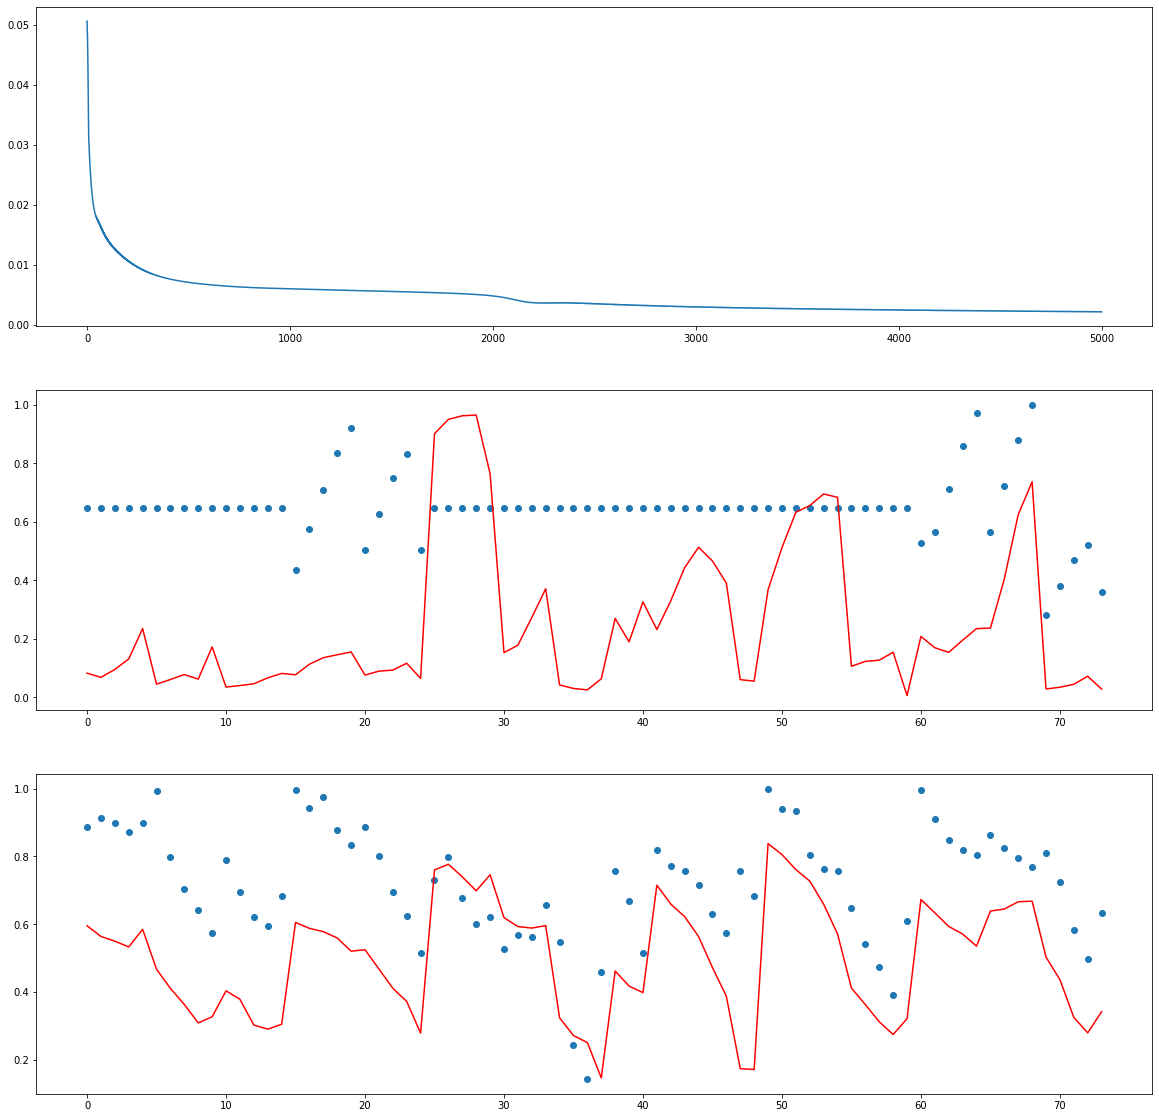

0.3820598735608019


In [0]:
fig = plt.gcf()
fig.set_size_inches(20, 20)

plt.subplot(3, 1, 1)
plt.plot(errors)

for class_index in range(2):
    plt.subplot(3, 1, 2 + class_index)
    draw_class(class_index, normalized_test_data, 2)

plt.show()
print(rmse(network, Network.prepare_data(normalized_test_data, 2)))

In [0]:
import seaborn as sb
plt.figure(figsize=(12,12))
# corr = pd.DataFrame(np.corrcoef(network.weights[2]))
corr = pd.DataFrame(network.weights[2])
sb.heatmap(corr, square=True, cmap='PiYG')

In [0]:
class RegularizedNetwork(Network):
    def __init__(self, shape, activation_function, activation_function_derivative, l1=0, l2=0):
        super().__init__(shape, activation_function, activation_function_derivative)
        self.l1 = l1
        self.l2 = l2

            # обновление параметров нейронной сети (веса, смещения), сделав шаг градиентного спуска
    # на основе алгоритма обратного распространения ошибки
    # alpha - learning rate
    def back_prop_step(self, data, alpha):
        # значения dJ/db для каждого слоя
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        # значения dJ/dw (ошибки) для каждого слоя
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # для каждого примера из батча применяем бек пропогейшн
        for x, y in data:
            delta_nabla_b, delta_nabla_w = self.back_prop_single_example(x, y)
            nabla_b = [nb + dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw + dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]

        eps = alpha / len(data)

        # обновляем параметры сети
        self.weights = [w - eps * nw - self.l1 * np.sign(w) - self.l2 * w for w, nw in zip(self.weights, nabla_w)]
        self.biases  = [b - eps * nb for b, nb in zip(self.biases,  nabla_b)]

In [0]:
network = RegularizedNetwork([18, 40, 60, 2], sigmoid, sigmoid_prime)
errors = network.SGD(normalized_train_data, 10000, 0.405, 2)